In [48]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

In [49]:
#Load dataset into a pandas dataframe
data = pd.read_csv("../data/Cleaned data/data.csv") 
data.dropna(inplace = True)
data.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,32.2,21.95,38.472917,6665.366167,23.465,01-2016,4,0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,21.7,21.00,36.907292,6236.849955,23.465,01-2016,5,1
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,10.3,21.55,31.997083,6551.924748,23.465,01-2016,6,1
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,6.4,20.90,33.424583,6729.993123,23.465,01-2016,0,0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,4.4,19.05,33.053958,7333.898202,23.465,01-2016,1,0


In [50]:
df = data.drop(['MIN','MAX', 'MONTHDATE','WEEKEND'], axis=1)
df.head()

#print(df.isna().sum())
# Check number of rows in df before join operation
print("Number of rows in df before join operation:", df.shape[0])

Number of rows in df before join operation: 2325


In [51]:
# Onehot Encoding for categorial data (Weekday)

# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df[['WEEKDAY']].reset_index(drop=True)

# Create a one-hot encoder object
encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df_encoded = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']).reset_index(drop=True)

#Drop weekday column
df = df.drop(['WEEKDAY'], axis=1)

# Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df.reset_index(drop=True), weekday_df_encoded], axis=1)

df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,21.95,38.472917,6665.366167,23.465,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,21.00,36.907292,6236.849955,23.465,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,21.55,31.997083,6551.924748,23.465,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,20.90,33.424583,6729.993123,23.465,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,19.05,33.053958,7333.898202,23.465,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Convert the 'date' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)

In [53]:
# Split the dataset into training and testing sets. 
train_set = np.where((df.index >= datetime(2017, 8, 1)) & (df.index < datetime(2021, 8, 1)))[0]
test_set = np.where(df.index >= datetime(2021, 8, 1))[0]

# identify response variable and predictors
X = df.drop(['TOTALDEMAND','FORECASTDEMAND'], axis=1).values
X_all = df.values[test_set] # save for plotting later
X_all_cols = list(df.columns)
y = df['TOTALDEMAND'].values


In [54]:
# Normalize the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X[train_set])
X_test_scaled = scaler_X.transform(X[test_set])

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y[train_set].reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y[test_set].reshape(-1, 1)).ravel()

print(X_test_scaled[:5])
print(X_train_scaled[:5])
print(y_test_scaled[:5])
print(y_train_scaled[:5])

[[1.         0.63636364 0.         0.45335607 0.40432429 0.
  0.2724359  0.38353765 0.23953648 0.12358105 0.         0.
  0.         0.         0.         0.         1.        ]
 [1.         0.63636364 0.03333333 0.45335607 0.40432429 1.
  0.36217949 0.21190893 0.31218315 0.12358105 1.         0.
  0.         0.         0.         0.         0.        ]
 [1.         0.63636364 0.06666667 0.55427801 0.22875414 0.
  0.39102564 0.32399299 0.2111023  0.12358105 0.         1.
  0.         0.         0.         0.         0.        ]
 [1.         0.63636364 0.1        0.49131993 0.38467382 0.
  0.40384615 0.16462347 0.33700286 0.12358105 0.         0.
  1.         0.         0.         0.         0.        ]
 [1.         0.63636364 0.13333333 0.32768625 0.56915181 0.
  0.41025641 0.24343257 0.22903169 0.12358105 0.         0.
  0.         1.         0.         0.         0.        ]]
[[0.         0.63636364 0.         0.54515261 0.48699955 0.
  0.38782051 0.18563923 0.7116133  0.10793701 0. 

In [55]:
#Reshape the data for input to the LSTM model
#(This step is fit the data to 3D tensor format for LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)
#using sliding window approach to create input-output pairs with timesteps n = 1

X_train = []
y_train = []
for i in range(1, len(X_train_scaled)):
    X_train.append(X_train_scaled[i-1:i, :])
    y_train.append(X_train_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

X_test = []
y_test = []
for i in range(1, len(X_test_scaled)):
    X_test.append(X_test_scaled[i-1:i, :])
    y_test.append(X_test_scaled[i, 1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

In [56]:
# Build the LSTM model with three LSTM layers and one Dense output layer 
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [57]:
# Training the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
45/45 [==============================] - 13s 70ms/step - loss: 0.3328 - val_loss: 0.3247
Epoch 2/50
45/45 [==============================] - 1s 24ms/step - loss: 0.2930 - val_loss: 0.2776
Epoch 3/50
45/45 [==============================] - 1s 15ms/step - loss: 0.2394 - val_loss: 0.2114
Epoch 4/50
45/45 [==============================] - 1s 15ms/step - loss: 0.1713 - val_loss: 0.1378
Epoch 5/50
45/45 [==============================] - 1s 14ms/step - loss: 0.1123 - val_loss: 0.1026
Epoch 6/50
45/45 [==============================] - 1s 11ms/step - loss: 0.0861 - val_loss: 0.0975
Epoch 7/50
45/45 [==============================] - 1s 13ms/step - loss: 0.0791 - val_loss: 0.0904
Epoch 8/50
45/45 [==============================] - 1s 13ms/step - loss: 0.0714 - val_loss: 0.0816
Epoch 9/50
45/45 [==============================] - 0s 11ms/step - loss: 0.0646 - val_loss: 0.0730
Epoch 10/50
45/45 [==============================] - 1s 22ms/step - loss: 0.0561 - val_loss: 0.0636
Epoch 11

In [58]:
# Make predictions on the test set
y_pred = model.predict(X_test)

11/11 [==============================] - 2s 2ms/step


In [59]:
# Calculate MSE and R-squared

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: %.4f' % mse)
print('R-squared: %.4f' % r2)

MSE: 0.0040
R-squared: 0.9626


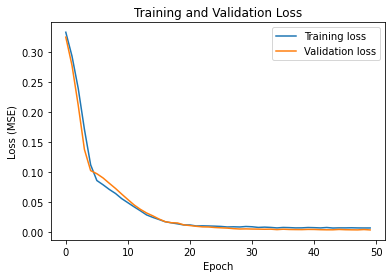

In [60]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

# Plot training and validation loss (MSE) for each epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


Plot Accuracy

In [61]:
df_lim = pd.DataFrame(X_all).iloc[:-1,:]
df_lim.columns = X_all_cols
df_lim['YEAR'] = df_lim['YEAR'].astype(int)
df_lim['MONTH'] = df_lim['MONTH'].astype(int)
df_lim['DAY'] = df_lim['DAY'].astype(int)
df_lim.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
0,2021,8,1,0.574894,23.255319,7335.822396,0.0,9.5,16.80,47.296000,7513.042369,73.48,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2021,8,2,0.574894,23.255319,8101.526979,2.0,12.3,11.90,55.460417,8327.524223,73.48,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021,8,3,0.647174,17.065217,8077.243715,0.0,13.2,15.10,44.100417,8331.968164,73.48,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2021,8,4,0.602083,22.562500,8461.227500,0.0,13.6,10.55,58.249787,8662.525274,73.48,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2021,8,5,0.484889,29.066667,8231.809201,0.0,13.8,12.80,46.115417,8467.645334,73.48,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [62]:
df_lim["YTEST"] = y_test
df_lim["YPRED"] = y_pred
df_lim["DATE"] = pd.to_datetime(df_lim[["YEAR", "MONTH", "DAY"]])
df_lim["FORECAST"] = df_lim["FORECASTDEMAND"].shift(-1)
df_lim = df_lim[["DATE","TOTALDEMAND","YTEST","YPRED","FORECAST"]]
df_lim = df_lim.dropna()
df_lim = df_lim.iloc[1:,:]

In [63]:
Date = df_lim.DATE
Forecast = df_lim.FORECAST
Pred = df_lim.YPRED
Test = df_lim.YTEST
df_lim.head()

,DATE,TOTALDEMAND,YTEST,YPRED,FORECAST
1,2021-08-02,8101.526979,0.636364,0.634148,8331.968164
2,2021-08-03,8077.243715,0.636364,0.614858,8662.525274
3,2021-08-04,8461.227500,0.636364,0.644181,8467.645334
4,2021-08-05,8231.809201,0.636364,0.612048,8193.368153
5,2021-08-06,8027.316944,0.636364,0.638448,7913.074493


C:\Users\mia.jensen\AppData\Local\Temp\ipykernel_26332\1181839280.py:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])


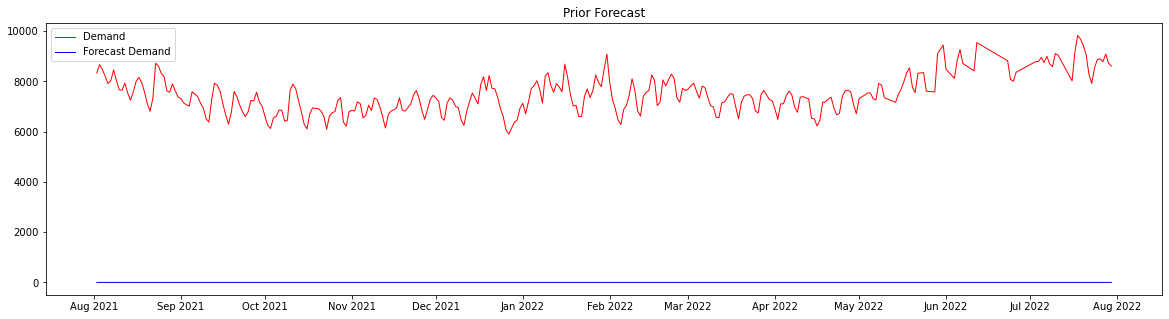

Mean Absolute Error: 7452.14
Root Mean Squared Error: 7489.06
R Squared Score: -521053342.74


In [64]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Forecast, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Prior Forecast")
plt.show()

# print prior model performance
mae1 = mean_absolute_error(Test, Forecast)
mse1 = mean_squared_error(Test, Forecast)
rmse1 = np.sqrt(mse1)
r21 = r2_score(Test, Forecast)
print("Mean Absolute Error: {:.2f}".format(mae1))
print("Root Mean Squared Error: {:.2f}".format(rmse1))
print("R Squared Score: {:.2f}".format(r21)) 

C:\Users\mia.jensen\AppData\Local\Temp\ipykernel_26332\1811583872.py:4: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])


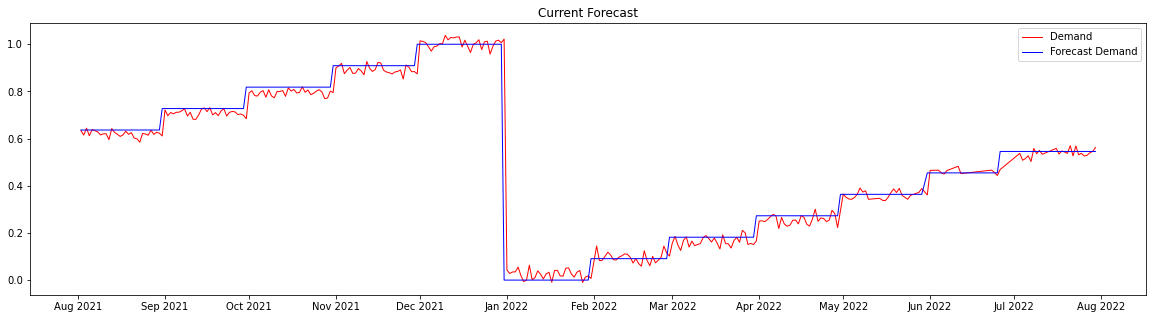

Mean Absolute Error: 0.03
Root Mean Squared Error: 0.06
R Squared Score: 0.96


In [65]:
fig, ax = plt.subplots(figsize=(20,5)) 
forecast = ax.plot(Date, Pred, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Current Forecast")
plt.show()

# print current model performance
mae2 = mean_absolute_error(Test, Pred)
mse2 = mean_squared_error(Test, Pred)
rmse2 = np.sqrt(mse2)
r22 = r2_score(Test, Pred)
print("Mean Absolute Error: {:.2f}".format(mae2))
print("Root Mean Squared Error: {:.2f}".format(rmse2))
print("R Squared Score: {:.2f}".format(r22)) 